## 1. Great Britain city names, population, and other information from [GeoNames.](https://www.geonames.org/)


### Necessary imports and Data preview:

In [37]:
#Import necessary libraries.

import pandas as pd  # For data loading, manipulation, and analysis (DataFrames, Series, etc.)
import numpy as np  # For numerical operations, arrays, and statistical computations
import matplotlib.pyplot as plt  # For basic plotting and visualizations
import seaborn as sns  # For attractive statistical visualizations (built on top of matplotlib)

from sklearn.impute import KNNImputer  # For imputing missing values using the K-Nearest Neighbors approach

from scipy.stats import shapiro  # For testing normality using the Shapiro-Wilk test


# Load dataset of Great Britain's GeoNames data from GitHub URL
# Reason for using Great Britain as the chosen country, is simply because it was the only manageable size file that mostly used the regular alphabet. The files for Finland, USA, South Africa, Australia, etc. were simply enormous.
file_path = "https://github.com/oskariOAK/Miniprojekti/raw/refs/heads/main/GB.txt"

import pandas as pd  # For data loading, manipulation, and analysis (DataFrames, Series, etc.)
# Load and preview

df = pd.read_csv(file_path, delimiter="\t", low_memory=False)
df.columns = ["geonameid", "name", "asciiname", "alternatenames", "latitude", "longitude", "feature class", "feature code", "country code", "cc2", "admin1 code", "admin2 code", "admin3 code", "admin4 code", "population", "elevation", "dem", "timezone", "modification date"]
print("Dataset Preview:")
print(df.head(5))

print("Descriptive statistics:")
print(df.describe())

print("Dataset info")
df.info()


Dataset Preview:
   geonameid                    name               asciiname alternatenames  \
0       5654      Glossa tou Shyllou      Glossa tou Shyllou            NaN   
1       5655                Arkosyia                Arkosyia            NaN   
2       5656          Ammoskatharaes          Ammoskatharaes            NaN   
3       5657  Skaloua Tris Kazoulies  Skaloua Tris Kazoulies            NaN   
4       5659           Shilliostasha           Shilliostasha            NaN   

   latitude  longitude feature class feature code country code  cc2  \
0  34.57083   33.02917             L         LCTY           GB  NaN   
1  34.57917   33.02500             L         LCTY           GB  NaN   
2  34.56795   33.01775             L         LCTY           GB  NaN   
3  34.57083   33.01667             L         LCTY           GB  NaN   
4  34.57500   33.02083             L         LCTY           GB  NaN   

  admin1 code admin2 code admin3 code admin4 code  population  elevation  dem  \


### 2. Handle missing data by first calculating how much there is of it and then later using a Shapiro-Wilk test to determine the data distibution.

In [4]:
# Handle Missing data, which there is a lot of.

missing_counts = df.isnull().sum()
print("Missing Data Count:\n", missing_counts)

# Function to check normality of numeric columns using the Shapiro-Wilk test

def check_distribution(df):
    distribution_results = {}  # Dictionary to store results for each numeric column

    # Loop through each numeric column in the DataFrame
    for column in df.select_dtypes(include=['number']).columns:
        # Drop missing values before testing
        stat, p = shapiro(df[column].dropna())
        
        # Classify distribution based on p-value
        distribution_results[column] = "Normal Distribution" if p > 0.05 else "Skewed Distribution"
    
    return distribution_results  # Return the dictionary of results

# Apply the function and print results
distribution_results = check_distribution(df)
print("Data Distribution Check:\n", distribution_results)


Missing Data Count:
 geonameid                 0
name                      0
asciiname                 0
alternatenames        45580
latitude                  0
longitude                 0
feature class             0
feature code              4
country code              0
cc2                  109059
admin1 code             355
admin2 code            3903
admin3 code           41646
admin4 code           74527
population                0
elevation             90046
dem                       0
timezone                288
modification date         0
dtype: int64
Data Distribution Check:
 {'geonameid': 'Skewed Distribution', 'latitude': 'Skewed Distribution', 'longitude': 'Skewed Distribution', 'population': 'Skewed Distribution', 'elevation': 'Skewed Distribution', 'dem': 'Skewed Distribution'}


C:\Users\Osku1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 109109.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\Osku1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19063.
  res = hypotest_fun_out(*samples, **kwds)


### 3. Use a function to determine the recommened imputation strategy for the missing data.

In [5]:
# Recommend Missing Data Imputation Strategy

def recommend_imputation(df, distribution_results):
    recommendations = {}  # Dictionary to store imputation recommendations for each column

    for column in df.columns:
        missing_count = df[column].isnull().sum()
        total_count = len(df)
        missing_percentage = (missing_count / total_count) * 100
        dist = distribution_results.get(column, "Not Checked")
        col_dtype = df[column].dtype

        print(f"\nColumn: {column}")
        print(f"Missing: {missing_count} ({missing_percentage:.2f}%)")
        print(f"Data Type: {col_dtype}")
        print(f"Distribution: {dist}")

        if missing_count == 0:
            print("Recommendation: No missing values")
            recommendations[column] = "No missing values"
            continue

        if col_dtype == 'object' or str(col_dtype) == 'category':
            # Categorical column
            if missing_percentage < 40:
                print("Recommendation: Use Mode Imputation (Categorical)")
                recommendations[column] = "Use Mode Imputation"
            else:
                print("Recommendation: Too many missing values — consider removing")
                recommendations[column] = "Too many missing values — consider removing"
        else:
            # Numeric column
            if missing_percentage < 5:
                print("Recommendation: Use Median Imputation")
                recommendations[column] = "Use Median Imputation"
            elif missing_percentage < 20:
                print("Recommendation: Use KNN Imputation or Median Imputation")
                recommendations[column] = "Use KNN Imputation or Median Imputation"
            elif missing_percentage < 30:
                print("Recommendation: Consider Multiple Imputation (MICE)")
                recommendations[column] = "Consider Multiple Imputation (MICE)"
            elif missing_percentage < 40:
                print("Recommendation: Use Model-Based Imputation")
                recommendations[column] = "Use Model-Based Imputation"
            else:
                print("Recommendation: Too many missing values — consider removing")
                recommendations[column] = "Too many missing values — consider removing"

    return recommendations

# Apply the function
missing_recommendations = recommend_imputation(df, distribution_results)


Column: geonameid
Missing: 0 (0.00%)
Data Type: int64
Distribution: Skewed Distribution
Recommendation: No missing values

Column: name
Missing: 0 (0.00%)
Data Type: object
Distribution: Not Checked
Recommendation: No missing values

Column: asciiname
Missing: 0 (0.00%)
Data Type: object
Distribution: Not Checked
Recommendation: No missing values

Column: alternatenames
Missing: 45580 (41.77%)
Data Type: object
Distribution: Not Checked
Recommendation: Too many missing values — consider removing

Column: latitude
Missing: 0 (0.00%)
Data Type: float64
Distribution: Skewed Distribution
Recommendation: No missing values

Column: longitude
Missing: 0 (0.00%)
Data Type: float64
Distribution: Skewed Distribution
Recommendation: No missing values

Column: feature class
Missing: 0 (0.00%)
Data Type: object
Distribution: Not Checked
Recommendation: No missing values

Column: feature code
Missing: 4 (0.00%)
Data Type: object
Distribution: Not Checked
Recommendation: Use Mode Imputation (Categor

### 4. Handle the missing data as suggested, and remove the columns which simply had too much missing data to begin with.

In [6]:
# As the recommended imputation suggests, we are removing columns for elevation, admin4 code and cc2, because they have too many missing values. 'alternatenames' also has too many missing values,
# but I believe the data there to be somewhat intriguing, so we are keeping it.

# Make a safe copy of the dataframe:
df_copy = df.copy()

# Drop said columns:
#df = df.drop(columns=["cc2", "admin4 code", "elevation"])

# Fill missing values using Mode Imputation.

for column in df.columns:
    mode_value = df[column].mode()[0]  # mode() returns a Series
    df.fillna({column: mode_value}, inplace=True)


# Check the data afterwards to make sure columns were removed:
print(df.head(5))

   geonameid                    name               asciiname alternatenames  \
0       5654      Glossa tou Shyllou      Glossa tou Shyllou        Newtown   
1       5655                Arkosyia                Arkosyia        Newtown   
2       5656          Ammoskatharaes          Ammoskatharaes        Newtown   
3       5657  Skaloua Tris Kazoulies  Skaloua Tris Kazoulies        Newtown   
4       5659           Shilliostasha           Shilliostasha        Newtown   

   latitude  longitude feature class feature code country code    cc2  \
0  34.57083   33.02917             L         LCTY           GB  GB,IE   
1  34.57917   33.02500             L         LCTY           GB  GB,IE   
2  34.56795   33.01775             L         LCTY           GB  GB,IE   
3  34.57083   33.01667             L         LCTY           GB  GB,IE   
4  34.57500   33.02083             L         LCTY           GB  GB,IE   

  admin1 code admin2 code admin3 code admin4 code  population  elevation  dem  \
0    

# Findings so far.
- The txt-file I downloaded had a lot of missing data, and it has probably had more, but some of it has already been fixed before GeoNames posted it for download.
- Funnily enough, I accidentally found out that the most common alternate name for a city in Great Britain is 'Newtown'. Which makes sense, but is also quite surprising, if not boring. I also accidentally removed 3 columns from the dataset, which I meant to do, but I thought for some reason that the decision wasn't permanent. Oops.
- All of the missing data has been removed and/or replaced with the MODE value of any given column. This turned out to be quite the bad decision on the 'alternatenames' column, since that wasn't really something that could just be replaced with the most common name.


## 5. Data exploration and Visualization:

    Most common place names:

C:\Users\Osku1\AppData\Local\Temp\ipykernel_35944\1576008713.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=name_counts.values, y=name_counts.index, palette='rocket')


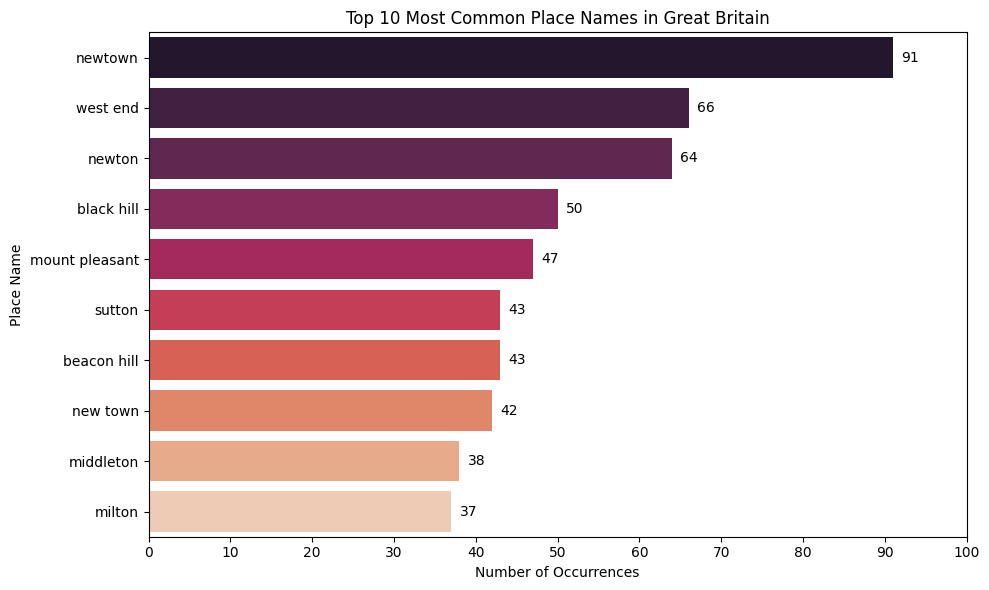

In [7]:
# Since the data is now cleaned up, we move on to exploring the data and visualizing it. Starting with most common city names.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get most common names
name_counts = df['name'].str.lower().value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=name_counts.values, y=name_counts.index, palette='rocket')

plt.title("Top 10 Most Common Place Names in Great Britain")
plt.xlabel("Number of Occurrences")
plt.ylabel("Place Name")

plt.xlim(0, 100)
plt.xticks(range(0, 101, 10))  # Explicitly set tick marks, this allows us to decide the spacing between the ticks manually.

# Add number to each bar
for i, value in enumerate(name_counts.values):
    ax.text(value + 1, i, str(value), color='black', va='center', ha='left')


plt.tight_layout()
plt.show()



    Realising near the end of the deadline for the project that I actually did have the population data in the dataset, which I had thought to be empty for the longest time and quickly added some visualization that showcased having this population data...

C:\Users\Osku1\AppData\Local\Temp\ipykernel_35944\1568770997.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='name', y='population', data=top_10_cities, palette='rocket')


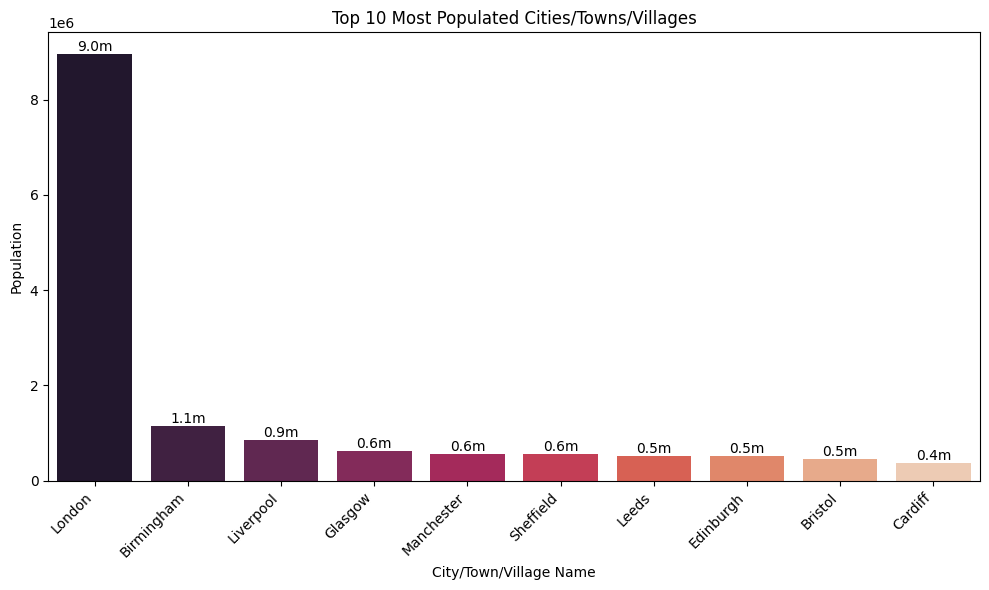

In [35]:
# Filter for places that are cities, towns, or villages
cities = df[df['feature class'] == 'P'].copy()

# Sort by population in descending order and get the top 10
top_10_cities = cities.sort_values(by='population', ascending=False).head(10)

# Create the bar graph using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='name', y='population', data=top_10_cities, palette='rocket')
plt.xlabel('City/Town/Village Name')
plt.ylabel('Population')
plt.title('Top 10 Most Populated Cities/Towns/Villages')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add population counts in millions at the end of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,
            f'{height / 1e6:.1f}m',  # Format to millions
            ha='center', va='bottom')

plt.show()

    Frequency of frequencies, showing how many unique place names there are and showing how many there are with 2... 3... 4 and so on appearances:

C:\Users\Osku1\AppData\Local\Temp\ipykernel_35944\778964525.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


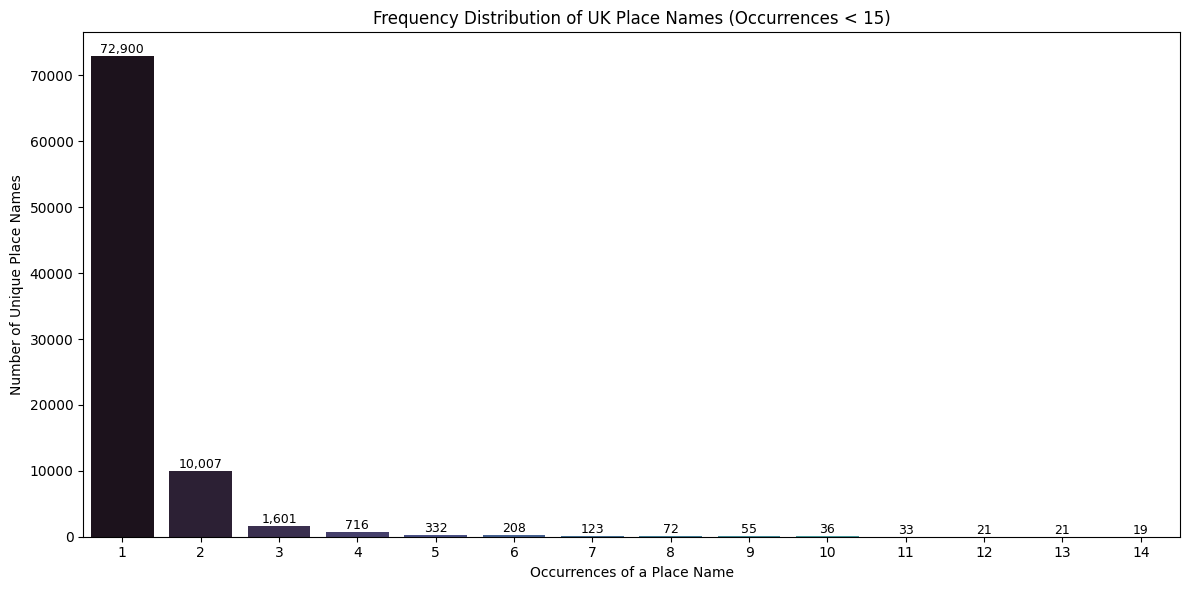

In [24]:
# Count how many times each place name occurs
name_counts = df['name'].value_counts()

# Count how often each frequency occurs
frequency_of_frequencies = name_counts.value_counts().sort_index()

# Limit to names that occur less than 15 times
limited_freqs = frequency_of_frequencies[frequency_of_frequencies.index < 15]

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=limited_freqs.index,
    y=limited_freqs.values,
    palette='mako'
)

# Add raw count labels at the top of the bars
for i, val in enumerate(limited_freqs.values):
    ax.text(i, val + 0.2, f"{val:,}", ha='center', va='bottom', fontsize=9)

plt.xlabel("Occurrences of a Place Name")
plt.ylabel("Number of Unique Place Names")
plt.title("Frequency Distribution of UK Place Names (Occurrences < 15)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The above graph shows the percentages of occurences of names in the dataset. Meaning that over 84.5% of the place names in the dataset occur only once and are unique.There are thousands of names in the dataset, so the bars look extremely small and difficult to read. Another thing is that the graph itself is slightly redundant as it does not properly portray a lot of the data, and is somewhat difficult to understand, which I will try to fix with this next graph.

C:\Users\Osku1\AppData\Local\Temp\ipykernel_35944\231771681.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


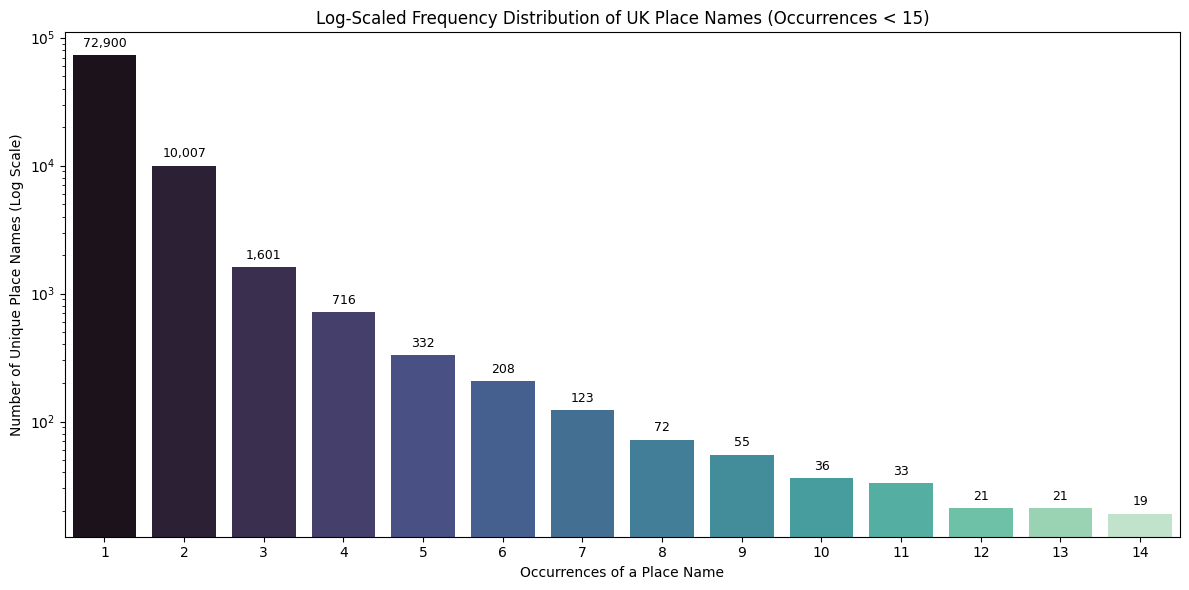

In [25]:
# Count how often each frequency occurs
frequency_of_frequencies = name_counts.value_counts().sort_index()

# Limit to names that occur less than 15 times
limited_freqs = frequency_of_frequencies[frequency_of_frequencies.index < 15]

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=limited_freqs.index,
    y=limited_freqs.values,
    palette='mako'
)

# Log scale on y-axis
ax.set_yscale('log')

# Add value labels (with slight offset for visibility)
for i, val in enumerate(limited_freqs.values):
    ax.text(i, val * 1.1, f"{val:,}", ha='center', va='bottom', fontsize=9)

plt.xlabel("Occurrences of a Place Name")
plt.ylabel("Number of Unique Place Names (Log Scale)")
plt.title("Log-Scaled Frequency Distribution of UK Place Names (Occurrences < 15)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

As we can see, using a log scale for the graph visualization allows for much, much better visual clarity and even makes the very small counts visible in the graph at the cost of making the difference between counts harder to distinguish at a quick glance. Overall though, I prefer this log scale for this problem, since it looks much nicer on the eyes when there is a visible curve to the graph. The interesting takeaway from this is that over 84.5% of the place names in the GeoNames UK dataset are unique and only appear one time. This percentage is much higher than I would have imagined.

### 6. Visualizing something different, this time I got the idea from ChatGPT to use the latitude and longitude values I had to make a visualization of those points using KMeans.

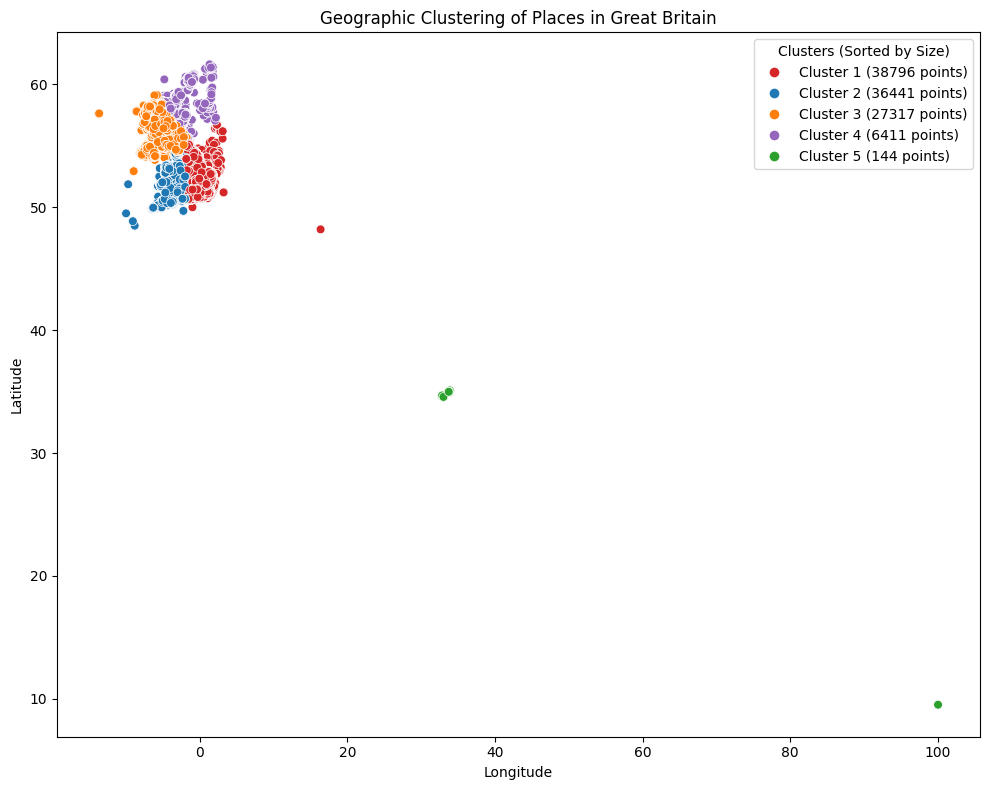

In [6]:
from sklearn.cluster import KMeans

# Clustering with KMeans (e.g. 5 clusters)
coords = df[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(coords)

# Run KMeans
coords = df[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(coords)

# Count and sort clusters by size (descending)
cluster_counts = df['cluster'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 8))
palette = sns.color_palette('tab10', n_colors=5)

# Create the scatterplot with actual cluster labels
scatter = sns.scatterplot(data=df, x='longitude', y='latitude', hue='cluster',
                          palette=palette, s=40, legend=False)

# Create custom legend, sorted by cluster size
handles = []
for display_idx, cluster_idx in enumerate(cluster_counts.index):
    label = f'Cluster {display_idx + 1} ({cluster_counts[cluster_idx]} points)'
    color = palette[cluster_idx]
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=8))

# Add legend
plt.legend(handles=handles, title='Clusters (Sorted by Size)', loc='upper right')

plt.title("Geographic Clustering of Places in Great Britain")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

### Continuation of plotting the latitude and longitudes of cities. This time a zoomed in view of the largest four clusters, ignoring the smaller ones, which probably are cities somewhere in southern Europe and Asia, given the coordinate values.

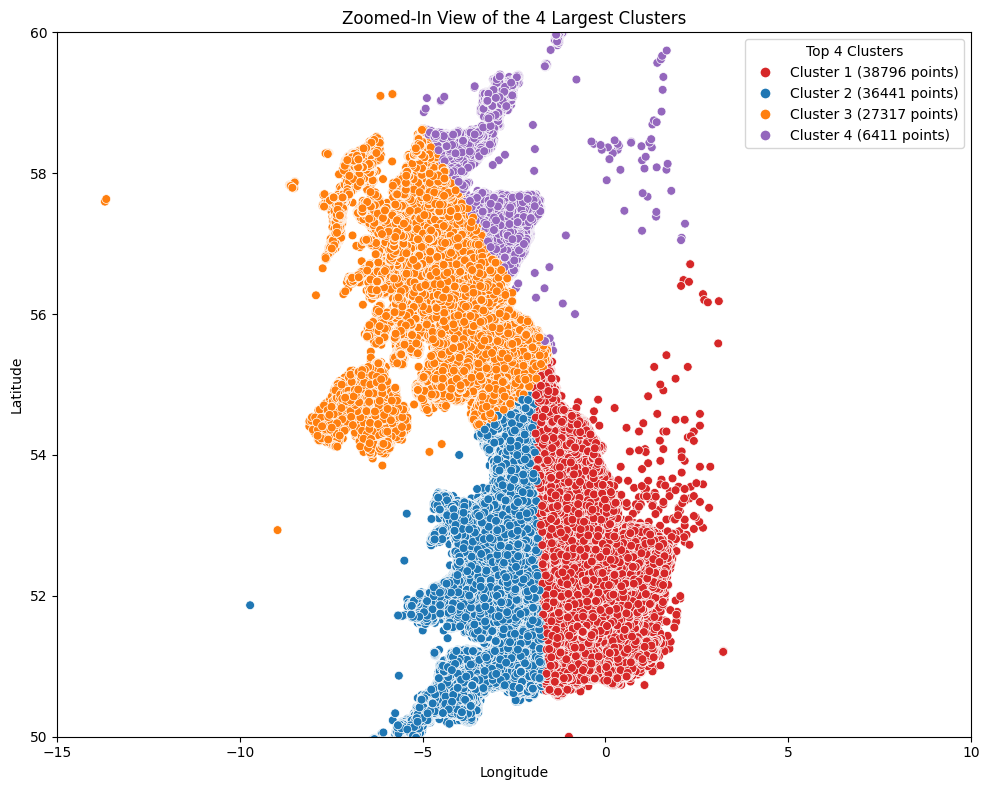

In [ ]:
# Run KMeans
coords = df[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(coords)

# Identify the top 4 largest clusters
cluster_counts_full = df['cluster'].value_counts()
top_clusters = cluster_counts_full.nlargest(4).index.tolist()
df_top = df[df['cluster'].isin(top_clusters)]

# Set the original color palette and create a mapping to clusters
base_palette = sns.color_palette('tab10', n_colors=5)
cluster_palette = {cluster_idx: base_palette[cluster_idx] for cluster_idx in range(5)}

# Plot only the top 4 clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_top,
    x='longitude',
    y='latitude',
    hue='cluster',
    palette=cluster_palette,
    s=40,
    legend=False
)

# Build a sorted legend with readable cluster labels
cluster_counts_top = df_top['cluster'].value_counts().sort_values(ascending=False)
handles = []
for display_idx, cluster_idx in enumerate(cluster_counts_top.index):
    label = f'Cluster {display_idx + 1} ({cluster_counts_top[cluster_idx]} points)'
    color = cluster_palette[cluster_idx]
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=color, markersize=8))

plt.legend(handles=handles, title='Top 4 Clusters', loc='upper right')

plt.title("Zoomed-In View of the 4 Largest Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-15, 10)
plt.ylim(50, 60)

plt.tight_layout()
plt.show()

# Findings of plotting the coordinates into a scatterplot and visualizing the most common country names.
The Brits seem to really like naming places in a very, very boring way. 'Newtown', 'new town', 'newton', 'Middle town', 'Middleton'. Its 5 out of the 10 most common place names are just slightly altered versions of 'Town' and an abbreviation to match.

Onto the scatterplots. The first one, portraying every single place that is owned by Great Britain(at least the ones in GeoNames' dataset.), shows that a very large portion of the places are centered in
Great Britain, which makes sense. You can also see that there are a few hundred points somewhere in Europe/Africa/Middle-East. Which historically does add up. There is also a singular point somewhere near Thailand, based on the coordinates, although it is very difficult to tell from the plot I made due to the huge amounts of empty space in between the dots. Not to mention that the scale is off if you were to place them on a world map.

The seconds scatterplot on the other hand is quite interesting. You can actually make out the shape of the island a little. The two largest clusters(Red and Blue), clearly are in the shape of the bottom of Great Britain. You can also make out Wales, Northern Ireland, and a little bit of the outline of Scotland.

![alt text](great_britain.jpg "Map of Great Britain to compare the above scatterplot to.")



### 7. Using a scatterplot to visualize density of place names:

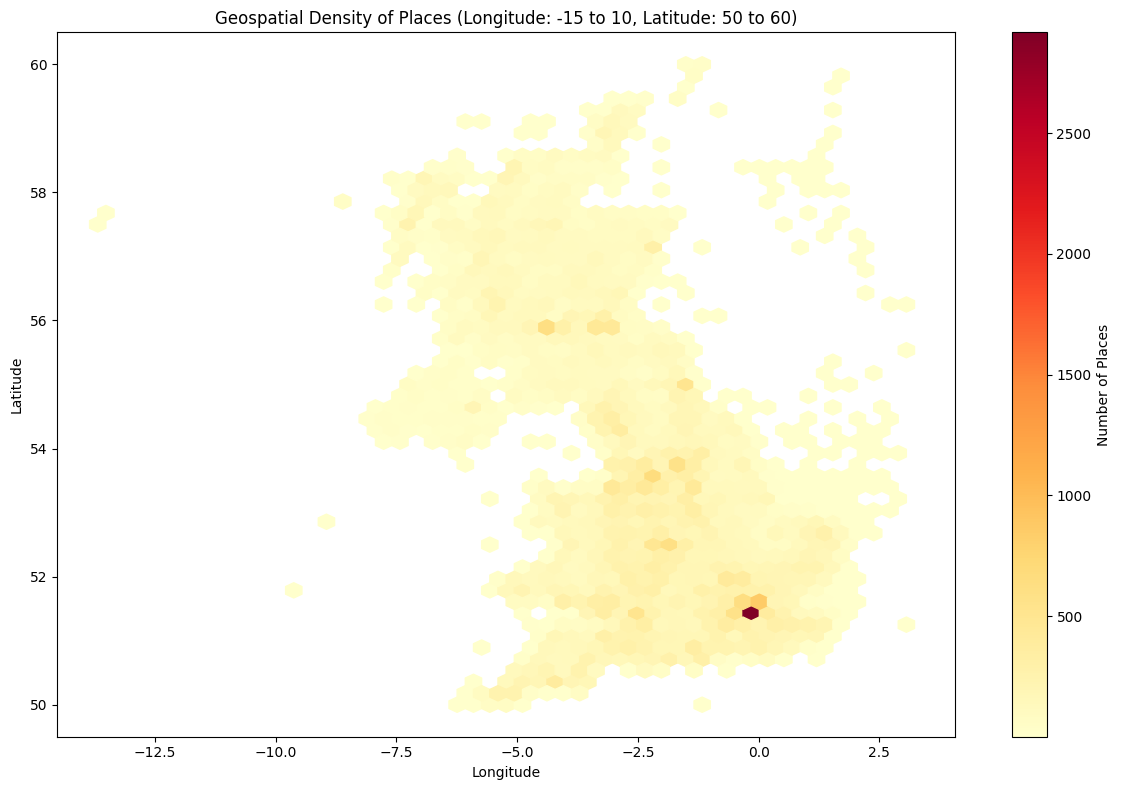

In [27]:
# Filter the dataset to only include places within the desired longitude and latitude range
df_filtered = df[(df['longitude'] >= -15) & (df['longitude'] <= 10) &
                 (df['latitude'] >= 50) & (df['latitude'] <= 60)]

# Create a hexbin plot for density of places
plt.figure(figsize=(12, 8))
plt.hexbin(df_filtered['longitude'], df_filtered['latitude'], gridsize=50, cmap='YlOrRd', mincnt=1)

# Add color bar to show number of places
plt.colorbar(label='Number of Places')

# Set labels and title
plt.title('Geospatial Density of Places (Longitude: -15 to 10, Latitude: 50 to 60)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Display the plot
plt.tight_layout()
plt.show()

As we can see from the density of place names plotted above, we can make out large hubs of civilization, in most cases have the largest number of living people in them. The very clear dark red spot for example is London and its surrounding areas. The darker yellow/slightly orange spots on the map on the other hand are hubs such as Manchester, Birmingham, Belfast, Edinburgh, etc. This is all done without using population data, and showcases a unique way that we can make out the largest hubs of civilization in the UK

### 8. Pie chart of different types of places in the dataset (Feature classes):

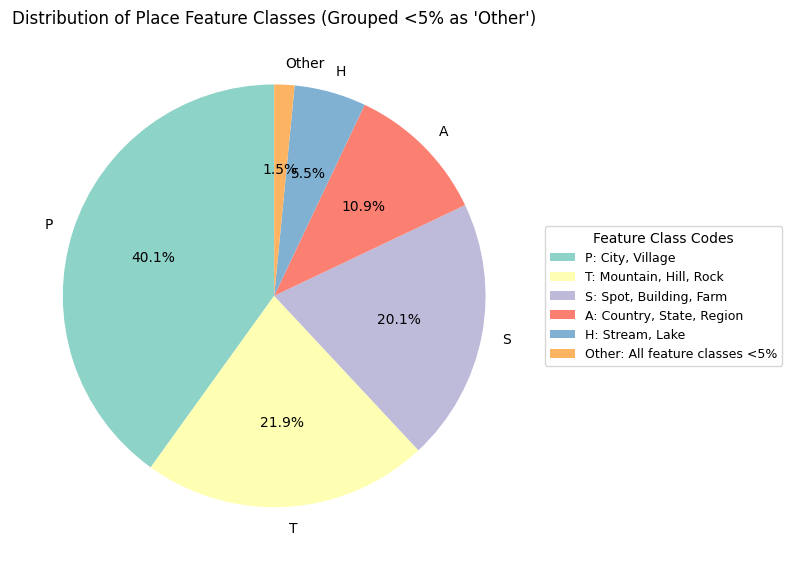

In [ ]:
# Get the count of each feature class
feature_class_counts = df['feature class'].value_counts()
total = feature_class_counts.sum()
threshold = 0.05 * total

# Group feature classes with <5% into 'Other'
feature_class_main = feature_class_counts[feature_class_counts >= threshold]
other_count = feature_class_counts[feature_class_counts < threshold].sum()
feature_class_grouped = feature_class_main.copy()
feature_class_grouped['Other'] = other_count

# Sort for consistency
feature_class_grouped = feature_class_grouped.sort_values(ascending=False)

# Define labels and sizes
labels = feature_class_grouped.index
sizes = feature_class_grouped.values

# Get matching number of distinct colors
colors = sns.color_palette('Set3', len(labels))

# Create pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)

# Feature class legend explanation
legend_labels = {
    'A': 'Country, State, Region',
    'H': 'Stream, Lake',
    'L': 'Parks, Area',
    'P': 'City, Village',
    'R': 'Road, Railroad',
    'S': 'Spot, Building, Farm',
    'T': 'Mountain, Hill, Rock',
    'U': 'Undersea',
    'V': 'Forest, Heath',
    'Other': 'All feature classes <5%'
}

# Create custom legend with matched colors
custom_legend_labels = []
custom_legend_colors = []

for label, color in zip(labels, colors):
    description = legend_labels.get(label, 'Unknown')
    custom_legend_labels.append(f"{label}: {description}")
    custom_legend_colors.append(color)

# Add legend with matching colors
plt.legend(wedges, custom_legend_labels, title="Feature Class Codes", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)

# Title and layout
plt.title("Distribution of Place Feature Classes")
plt.tight_layout()
plt.show()

From the above pie chart we can see that the most common feature class, as expected is city, village, town etc. Closely followed by natural geographical occurences such as rocks, mountains and hills that have names, then Farms, buildings and so on. This visualization also gives an answer to the earlier surprise that I had about over 84.5% of the dataset consisting of unique names. I had thought it was only city names and town names, but now that we can see that there are a lot of mountains, farms, rocks, hills, rivers, lakes and so on, it makes sense that there are a whole lot of unique names in the dataset.

### 9. Synopsis:

The GeoNames dataset for Great Britain was full of missing values which caused some of the columns of data to be unusable. Even something like 'alternate names' was difficult to utilize in a good way because it had lots of empty rows. I would have also liked to explore the whole worlds dataset, which could have made for even more interesting visualizations of the same types as I already showed. Like showing a pseudo map of the entire world with all of the largest hubs clearly showing up as dark red spots like in the heat map I showed of places in the UK. It would have also been interesting to explore the population data further, but as I mention earlier in this assignment, I completely mistook the population counts to be empty after reading shortly exploring the dataset... which I much later on realised was actually due to the fact that the names I had seen in the dataset were geographical locations so of course their population was 0. The GeoNames dataset was far from perfect, but it provided me with the possibility of exploring cool geographical data and they had data of around at least a 100 different countries downloadable for free which was really cool. One large thing that was missing, was any real possibility for time based analysis, due to the dataset not having any real time based data. Yes, there was modification date, but this did not accurately represent something new like a new town being founded, since the dataset is updated very regularly and a lot of the rows had been modified multiple times.

**Full disclosure, I used AI tools to assist me in creating more visually pleasant and more readable visualizations.**

***Oskari Ala-Kulju***